# Optimize Hyper-Paramters with GridSeachCV

In [1]:
import sklearn
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [2]:
train = pd.read_csv('data/train_clean.csv')

In [3]:
train.head()

,id,query,product_title,product_description,median_relevance,query_in_title
0,1,30,975,12875,1.0,False
1,2,121,23002,13442,4.0,False
2,4,170,27237,11025,4.0,False
3,5,249,5364,10063,4.0,False
4,7,127,28099,21698,2.0,False


In [4]:
y = train.median_relevance
train = train.drop(['median_relevance', 'id'], axis=1)

## Define functions to print scores

In [5]:
def display_result(grid_search):
    print("Params:", grid_search.best_params_)
    print("Score:", np.sqrt(-grid_search.best_score_))

In [6]:
def display_scores_cv(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("STD:", scores.std())

## GradientBoostingRegressor

In [8]:
from sklearn.ensemble import GradientBoostingClassifier

In [9]:
gb_reg = GradientBoostingClassifier(random_state=2308, min_samples_leaf=30)

In [10]:
param_grid_gb = [
    {
        'n_estimators': [50,100],
        'max_depth': [3,7]
     }
]

In [11]:
grid_search_gb = GridSearchCV(gb_reg, param_grid_gb, cv=5, scoring='neg_mean_squared_error')
grid_search_gb.fit(train,y)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=30, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=2308, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [50, 100], 'max_depth': [3, 7]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [12]:
display_result(grid_search_gb)

Params: {'max_depth': 7, 'n_estimators': 100}
Score: 1.0745564922405173


In [13]:
gb_scores = cross_val_score(grid_search_gb.best_estimator_, train, y, scoring="neg_mean_squared_error", cv=5)
gb_rmse_scores = np.sqrt(-gb_scores)
display_scores_cv(gb_rmse_scores)

Scores: [1.09463657 1.07334381 1.07864094 1.05487077 1.07088656]
Mean: 1.0744757290751579
STD: 0.012824400637371107


## Check for overfitting

In [15]:
train_check = pd.read_csv('data/train_clean.csv')
from sklearn.model_selection import train_test_split
train_check = train_check.drop(['id'], axis=1)

x_train, x_valid = train_test_split(train_check, test_size=0.2, random_state=123)
y_train = x_train.pop('median_relevance')
y_valid = x_valid.pop('median_relevance')

mse = metrics.mean_squared_error(y_valid, grid_search_gb.best_estimator_.predict(x_valid))
rmse = np.sqrt(mse)
print(rmse)

mse_t = metrics.mean_squared_error(y_train, grid_search_gb.best_estimator_.predict(x_train))
rmse_t = np.sqrt(mse_t)
print(rmse_t)

0.9781068006029948
0.9495586019101394


## Plot Feature Importance Values

In [16]:
feature_importances = pd.DataFrame(data= { 'feature_importance_values':
                                          grid_search_gb.best_estimator_.feature_importances_}, index=train.columns.values)
feature_importances.sort_values('feature_importance_values')

,feature_importance_values
query_in_title,0.004799
product_description,0.249516
query,0.372286
product_title,0.373398


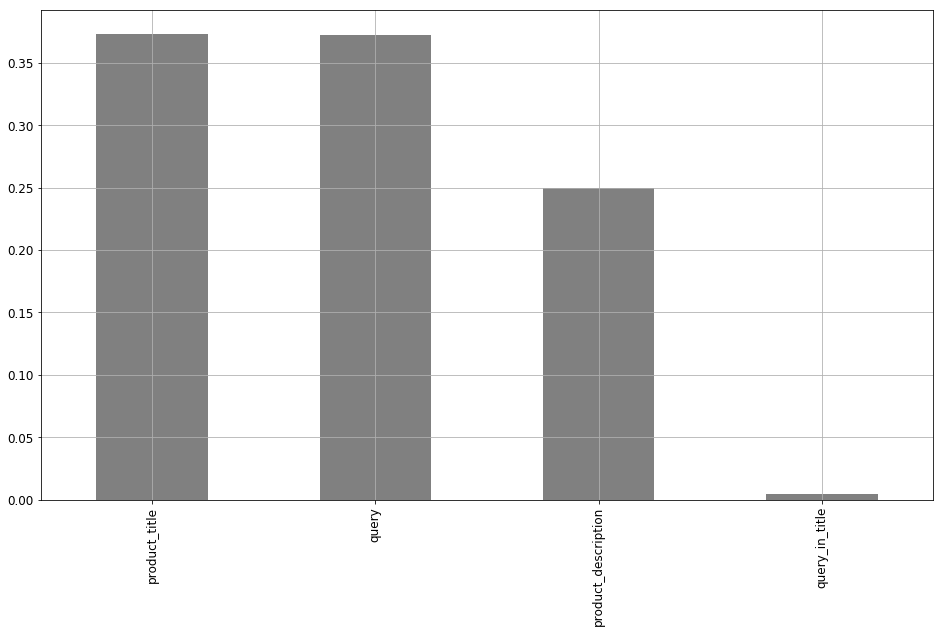

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
feature_importances.sort_values('feature_importance_values', ascending=False).plot(capsize=5, legend=False, grid=True,color ='grey', kind='bar', figsize= (16,9))

plt.show()